# Simulation of Complex Systems - Chapter 5

**Author**: Artur Gasparyan

## Exercise 5.1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.constants

In [2]:
n_steps = 1000
n_walks = 10000
sim_size = n_walks, n_steps

rng = np.random.default_rng()

outcomes_bernoulli = rng.choice([-1, 1], sim_size)
outcomes_gaussian = rng.normal(size=sim_size)
outcomes_asymmetry = rng.choice(
    [-1, (1-math.sqrt(3))/2, (1+math.sqrt(3))/2], size=sim_size
)

outcomes_all = outcomes_bernoulli, outcomes_gaussian, outcomes_asymmetry
trajectories_all = tuple(np.cumsum(o, axis=1) for o in outcomes_all)

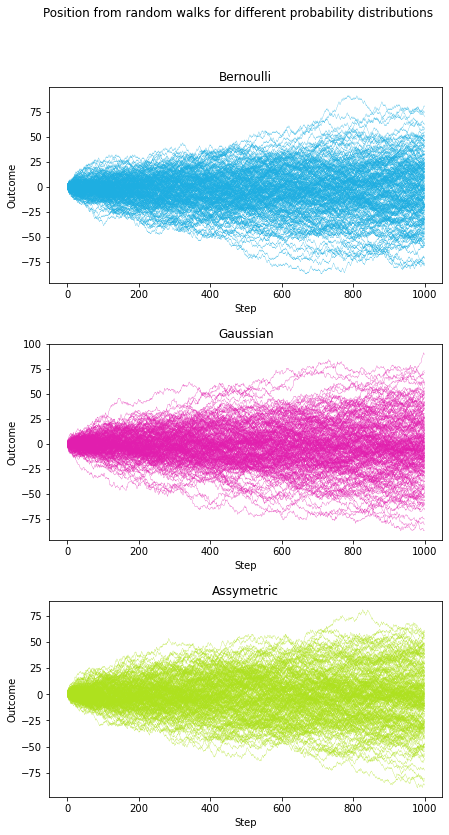

In [3]:
fig, axes = plt.subplots(3, 1, figsize=(7, 12))
fig.suptitle("Position from random walks for different probability distributions")
titles = ["Bernoulli", "Gaussian", "Assymetric"]
colors = ["#1EAEE1", "#E11EAE", "#AEE11E"]
fig.tight_layout(pad=4)

for trajectory, axis, title, color in zip(trajectories_all, axes, titles, colors):
    axis.plot(np.arange(n_steps), trajectory[:200].T, linewidth=0.25, color=color);
    axis.set_xlabel("Step")
    axis.set_ylabel("Outcome")
    axis.set_title(title)
    


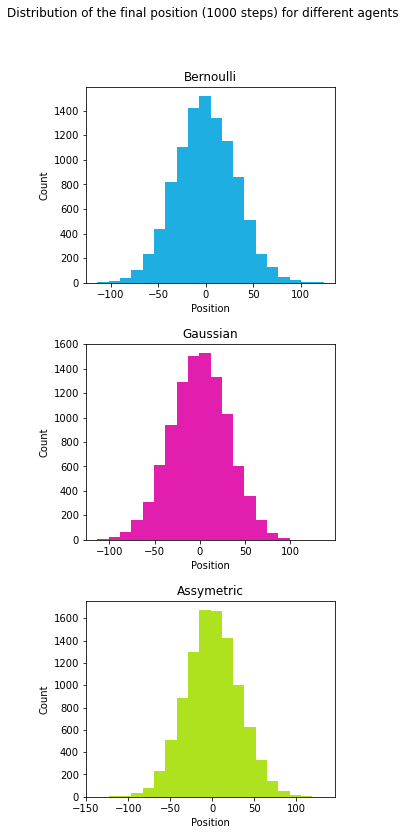

In [4]:
fig, axes = plt.subplots(3, 1, figsize=(5, 12))
fig.suptitle("Distribution of the final position (1000 steps) for different agents")
titles = ["Bernoulli", "Gaussian", "Assymetric"]
colors = ["#1EAEE1", "#E11EAE", "#AEE11E"]
fig.tight_layout(pad=4)

for trajectory, axis, title, color in zip(trajectories_all, axes, titles, colors):  
    axis.hist(trajectory[:, -1], 20, color=color)
    axis.set_xlabel("Position")
    axis.set_ylabel("Count")
    axis.set_title(title)

## Exercise 5.2

In [5]:
time = 5
n_walks = 50
time_steps = [0.01, 0.05, 0.10]


def get_white_noise_trajectory(nz_walks, time_step):
    n_steps = int(time/time_step)
    trajectory = np.cumsum(rng.normal(size=(n_walks, n_steps)), axis=1)
    return trajectory


trajectories_wn = [get_white_noise_trajectory(n_walks, time_step) for time_step in time_steps]

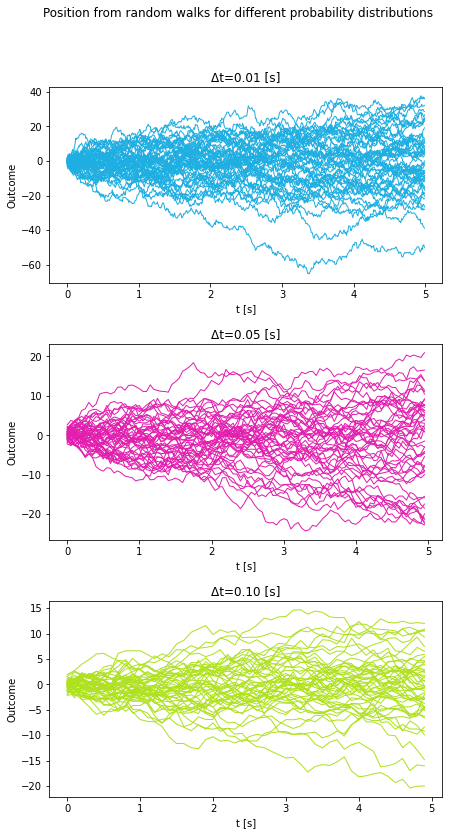

In [6]:
fig, axes = plt.subplots(3, 1, figsize=(7, 12))
fig.suptitle("Position from random walks for different probability distributions")
titles = ["Δt=0.01 [s]", "Δt=0.05 [s]", "Δt=0.10 [s]"]
colors = ["#1EAEE1", "#E11EAE", "#AEE11E"]
fig.tight_layout(pad=4)

for trajectory, time_step, axis, title, color in zip(trajectories_wn, time_steps, axes, titles, colors):
    t = np.arange(int(time/time_step))*time_step
    axis.plot(t, trajectory.T, linewidth=1, color=color);
    axis.set_xlabel("t [s]")
    axis.set_ylabel("Outcome")
    axis.set_title(title)


In [7]:
n_walks = 10000
trajectories_wnl = [get_white_noise_trajectory(n_walks, time_step) for time_step in time_steps]
msd_wnl = [np.mean(traj**2, axis=0) for traj in trajectories_wnl]

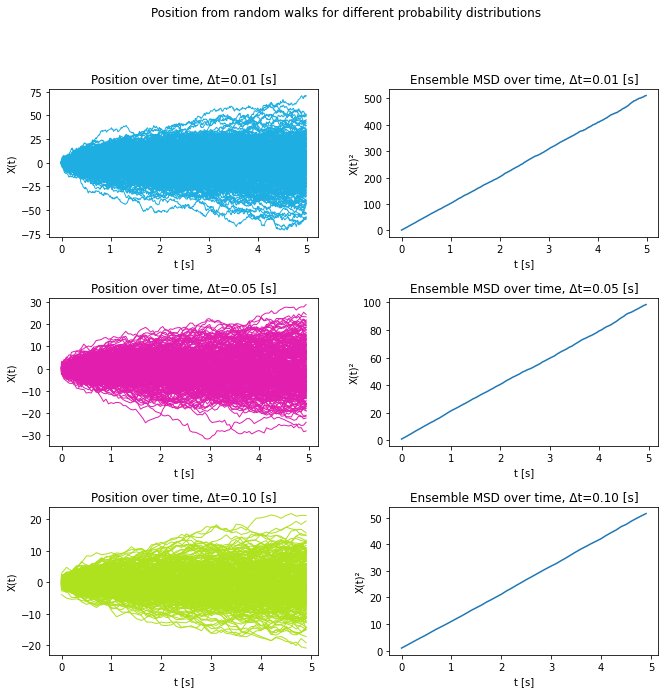

In [8]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
fig.suptitle("Position from random walks for different probability distributions")
titles = ["Δt=0.01 [s]", "Δt=0.05 [s]", "Δt=0.10 [s]"]
colors = ["#1EAEE1", "#E11EAE", "#AEE11E"]
fig.tight_layout(pad=4)

for (
    trajectory, msd, time_step, axis_hi, axis_lo, title, color
) in zip(
    trajectories_wnl, msd_wnl, time_steps, axes[:, 0], axes[:, 1], titles, colors
):
    t = np.arange(int(time/time_step))*time_step
    
    axis_hi.plot(t, trajectory[:300].T, linewidth=1, color=color);
    axis_hi.set_title(f"Position over time, {title}")
    axis_hi.set_xlabel("t [s]")
    axis_hi.set_ylabel("X(t)")

    axis_lo.plot(t, msd)
    axis_lo.set_title(f"Ensemble MSD over time, {title}")
    axis_lo.set_xlabel("t [s]")
    axis_lo.set_ylabel("X(t)²")
    



## Exercise 5.3

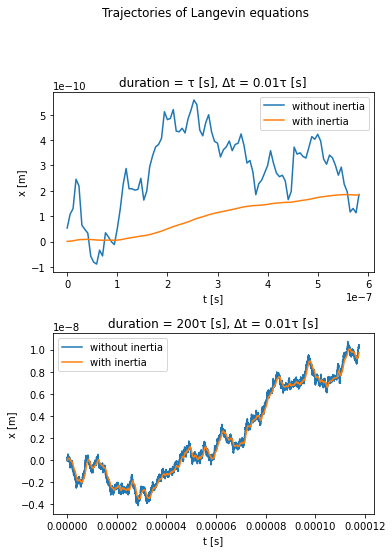

In [9]:
def get_langevic_trajectory(time_step, duration, use_mass, gaussian_seq):
    assert time_step < 0.1*duration
    
    eta = 0.001
    rad = 1E-6
    mass = 1.11E-14
    temp = 300
    gamma = 6*math.pi*eta*rad
    dt = time_step
    kb = scipy.constants.Boltzmann
    w = gaussian_seq
    
    n_steps = int(duration/time_step)
    x = np.zeros(n_steps)
    
    if use_mass:
        time_term = dt*gamma/mass
        factor_1 = (2+time_term)/(1+time_term)
        factor_2 = -1/(1+time_term)
        factor_3 = math.sqrt(2*kb*temp*gamma)/(mass+dt*gamma)*dt**1.5
    
        for i in range(n_steps):
            x[i] = (
                factor_1 * x[i-1] +
                factor_2 * x[i-2] +
                factor_3 * w[i]
            )
            
    else:
        factor = math.sqrt(2*kb*temp*dt/gamma)
        
        for i in range(n_steps):
            x[i] = x[i-1] + factor * w[i]
    
    return x


tau = 0.588E-6
time_step = 0.01*tau
duration = 200*tau
n_particles = 10

n_steps_long = int(duration/time_step)
n_steps_short = int(tau/time_step)

gaussian_seq = rng.normal(size=(n_steps_long,))

lang_m = get_langevic_trajectory(time_step, duration, use_mass=True, gaussian_seq=gaussian_seq)
lang_nm = get_langevic_trajectory(time_step, duration, use_mass=False, gaussian_seq=gaussian_seq)
 
t_short = np.arange(n_steps_short)*time_step
t_long = np.arange(n_steps_long)*time_step
    
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))
fig.suptitle("Trajectories of Langevin equations")
fig.tight_layout(pad=4)

ax1.plot(t_short, lang_nm[:n_steps_short])
ax1.plot(t_short, lang_m[:n_steps_short])
ax1.set_xlabel("t [s]")
ax1.set_ylabel("x [m]")
ax1.set_title("duration = τ [s], Δt = 0.01τ [s]")
ax1.legend(["without inertia", "with inertia"])

ax2.plot(t_long, lang_nm)
ax2.plot(t_long, lang_m)
ax2.set_xlabel("t [s]")
ax2.set_ylabel("x [m]")
ax2.set_title("duration = 200τ [s], Δt = 0.01τ [s]")
ax2.legend(["without inertia", "with inertia"])

...;

## Exercise 5.4

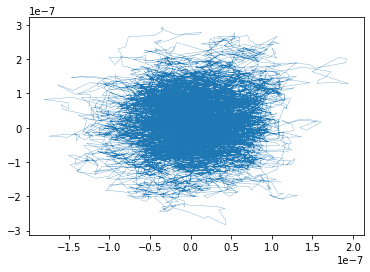

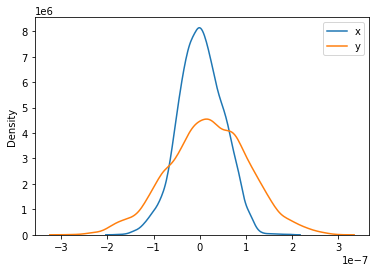

In [10]:
radius = 1E-6
eta = 0.001
gamma = 6*math.pi*eta*radius
temp = 300
k = np.array([1E-6, 0.25E-6])
kb = scipy.constants.Boltzmann


def get_trapped_trajectory(n_steps, time_step, gaussian_seq):
    w = gaussian_seq
    dt = time_step
        
    assert 1E-6 < time_step < gamma/np.mean(k)
    
    factor_1 = -k/gamma*dt
    factor_2 = math.sqrt(2*kb*temp*dt/gamma)
        
    x = np.zeros((n_steps, 2))
    
    for i in range(n_steps):
        x[i] = x[i-1] + factor_1 * x[i-2] + factor_2 * w[i]
        
    return x

n_steps = 10000
time_step = 0.001
gaussian_seq = rng.normal(size=(n_steps,2)) / np.sqrt(2)

trajectory_trap = get_trapped_trajectory(n_steps, time_step, gaussian_seq)
plt.plot(trajectory_trap[:, 0], trajectory_trap[:, 1], linewidth=0.25)

fig = plt.figure()
ax = plt.gca()
sns.kdeplot(trajectory_trap[:, 0], ax=ax)
sns.kdeplot(trajectory_trap[:, 1], ax=ax)
ax.legend(["x", "y"])

...;

In [11]:
def get_autocorr_theory(n_steps, time_step):
    ac = np.zeros((n_steps, 2))

    k_x, k_y = k
    
    ac[:, 0] = kb*temp/k_x*np.exp(-k_x/gamma*np.arange(n_steps)*time_step)
    ac[:, 1] = kb*temp/k_y*np.exp(-k_y/gamma*np.arange(n_steps)*time_step)

    return ac

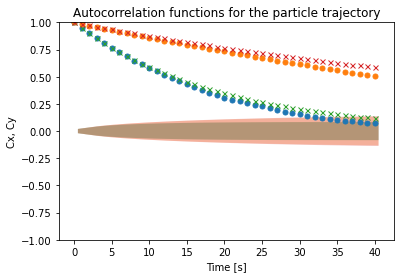

In [12]:
import statsmodels.api as sm

ac_theory = get_autocorr_theory(n_steps, time_step)

fig = plt.figure()
ax = plt.gca()
sm.graphics.tsa.plot_acf(trajectory_trap[:, 0], ax=ax, use_vlines=False)
sm.graphics.tsa.plot_acf(trajectory_trap[:, 1], ax=ax, use_vlines=False)
sm.graphics.tsa.plot_acf(ac_theory[:, 0], ax=ax, use_vlines=False, marker='x', adjusted=True)
sm.graphics.tsa.plot_acf(ac_theory[:, 1], ax=ax, use_vlines=False, marker='x')
ax.set_ylabel("Cx, Cy")
ax.set_xlabel("Time [s]")
ax.set_title("Autocorrelation functions for the particle trajectory")

...;

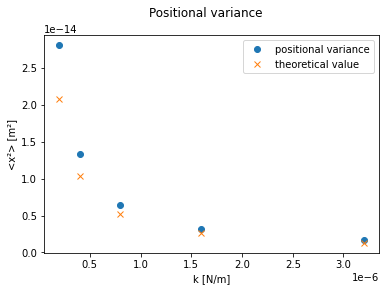

In [13]:
def get_trapped_trajectory_1d(n_steps, time_step, gaussian_seq, k):
    w = gaussian_seq
    dt = time_step
        
    assert 1E-6 < time_step < gamma/k
    
    factor_1 = -k/gamma*dt
    factor_2 = math.sqrt(2*kb*temp*dt/gamma)
        
    x = np.zeros((n_steps, ))
    
    for i in range(n_steps):
        x[i] = x[i-1] + factor_1 * x[i-2] + factor_2 * w[i]
        
    return x


n_steps = 10000
time_step = 0.001
gaussian_seq = rng.normal(size=(n_steps,))
k_values = 1E-6*np.array([0.2, 0.4, 0.8, 1.6, 3.2])
var_theory = kb*temp/k_values

variances = np.array(
    [np.var(get_trapped_trajectory_1d(n_steps, time_step, gaussian_seq, k)) for k in k_values]
)

fig = plt.figure()
fig.suptitle("Positional variance")
ax = plt.gca()
ax.plot(k_values, variances, linestyle='None', marker='o')
ax.plot(k_values, var_theory, linestyle='None', marker='x')
ax.legend(["positional variance", "theoretical value"])
ax.set_ylabel("<x²> [m²]")
ax.set_xlabel("k [N/m]")

...;

## Finalizing

In [14]:
!pip install nbconvert[webpdf] -q
!jupyter nbconvert --to webpdf --allow-chromium-download chapter-5.ipynb

[NbConvertApp] Converting notebook chapter-5.ipynb to webpdf
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 829056 bytes to chapter-5.pdf
